## Analysis of the repeatability for the full glycolysis network - Fructose substrate
#### Experiment code : SNMS34-35

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns; sns.set_theme(style='ticks', context='paper')
import colorcet as cc
import glob

import toml

In [2]:
#Definition of constants
TIMEBIN = 90 #Binning (~45s)

### Isotopic ratios for isotopic correction (15N-Glu, NADH) ###
Glu_13C_isotope = 0.0546 # Percentage of signal of glutamate isotope (146) to remove from 15N-glutamate (147)
NAD_2_13C_isotope = 0.0245 # Percentage of signal of NAD isotope (662) to remove from NADH (664)
Glu_conc_ratio = 0.104429302 #Ratio of concentrations of glutamate (0.05517 mM) and 15N-glutamate (0.5283 mM)


### NMR concentrations ###
F_concentration = 0.09288 # mM
G_concentration = 0.07956 # mM
G6P_concentration = 0.08957 # mM
F6P_concentration = 0.07707 # mM
FBP_concentration = 0.05594 # mM
ATP_concentration = 0.05 # mM
Pyr_concentration = 0.0912 # mM
Lac_concentration = 0.096288 # mM
PG_concentration = 0.088709 # mM
PEP_concentration = 0.09325 # mM

### Frag ratios ###
FBPtoF6P = 0.071
FtoLac = 0.058
GtoLac = 0.038

## Reading the data and conditions

In [3]:
OFFSET = 0
flow_parameters = toml.load("conditions/SNMS34_flowparameters.toml")
inputs = np.array([[c['length'], c['syringe_parameters']['F']['reactor_concentration'], 
                    c['syringe_parameters']['ATP']['reactor_concentration'], 
                    c['syringe_parameters']['ADP']['reactor_concentration'], 
                    c['syringe_parameters']['NAD']['reactor_concentration']] 
                    for c in flow_parameters['sections']
                ])

df_inputs = pd.DataFrame(
        inputs, columns=['time', 'F', 'ATP', 'ADP', 'NAD']
    ).assign(time = np.cumsum(inputs[:,0]))
print(df_inputs)
#correcting the inputs for time in minutes
df_inputgraph = df_inputs.copy()
df_inputgraph['time'] = (df_inputs['time'] / 60) - 60 #in minutes, minus the first 60 minutes of equilibration

       time     F   ATP   ADP  NAD
0    1800.0  4.50  1.50  1.50  1.5
1    7000.0  4.50  2.25  0.75  1.5
2   10600.0  3.00  2.25  0.75  1.5
3   14200.0  1.50  2.25  0.75  1.5
4   17800.0  0.75  2.25  0.75  1.5
5   21400.0  4.50  0.75  2.25  1.5
6   25000.0  3.00  0.75  2.25  1.5
7   28600.0  1.50  0.75  2.25  1.5
8   32200.0  0.75  0.75  2.25  1.5
9   35800.0  4.50  2.25  0.75  1.0
10  39400.0  3.00  2.25  0.75  1.0
11  43000.0  1.50  2.25  0.75  1.0
12  46600.0  0.75  2.25  0.75  1.0
13  50200.0  4.50  0.75  2.25  1.0
14  53800.0  3.00  0.75  2.25  1.0
15  57400.0  1.50  0.75  2.25  1.0
16  61000.0  0.75  0.75  2.25  1.0


In [4]:
sumdf_34 = pd.DataFrame()
    
try:
    with open(f"data/SNMS34/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf_34["retention_time"] = df_Time
        
fileList_34=glob.glob(f"data/SNMS34/*.xy")
fileList_34.remove(f"data/SNMS34\\TIC.xy")
    
for file in fileList_34:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf_34[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf_34 = sumdf_34.assign(retention_time = sumdf_34.retention_time.round(1))
sumdf_34 = sumdf_34.set_index('retention_time')

#Interpolation to compare both datasets
desired_index = range(50, 63500, 50)
sumdf_34 = sumdf_34.reindex(sumdf_34.index.union(desired_index)).interpolate(method='linear').reindex(desired_index)

#print(sumdf_34)


In [5]:
sumdf_35 = pd.DataFrame()
    
try:
    with open(f"data/SNMS35/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf_35["retention_time"] = df_Time
        
fileList_35=glob.glob(f"data/SNMS35/*.xy")
fileList_35.remove(f"data/SNMS35\\TIC.xy")
    
for file in fileList_35:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf_35[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf_35 = sumdf_35.assign(retention_time = sumdf_35.retention_time.round(1))
sumdf_35 = sumdf_35.set_index('retention_time')

#Interpolation to compare both datasets
sumdf_35 = sumdf_35.reindex(sumdf_35.index.union(desired_index)).interpolate(method='linear').reindex(desired_index)

#print(sumdf_35)


In [6]:
#Calculation of the flow ratios between dilution line and reactor
sumdf_34["Flow ratio"] = ((sumdf_34["L_Glu"] - (Glu_13C_isotope*sumdf_34["Glu"]))/(sumdf_34["Glu"]))*(Glu_conc_ratio)
sumdf_34["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

sumdf_35["Flow ratio"] = ((sumdf_35["L_Glu"] - (Glu_13C_isotope*sumdf_35["Glu"]))/(sumdf_35["Glu"]))*(Glu_conc_ratio)
sumdf_35["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

### Getting the metabolite concentrations

In [7]:
quantif_df = pd.DataFrame()

quantif_df.index = sumdf_34.index

quantif_df['F_34'] = (sumdf_34['L_F'] / sumdf_34['F'])*(F_concentration / sumdf_34["Flow ratio"])
quantif_df['F_35'] = (sumdf_35['L_F'] / sumdf_35['F'])*(F_concentration / sumdf_35["Flow ratio"])
quantif_df['ATP_34'] = (sumdf_34['ATP_2+'] / sumdf_34['L_ATP_2+'])*(ATP_concentration / sumdf_34["Flow ratio"])
quantif_df['ATP_35'] = (sumdf_35['ATP_2+'] / sumdf_35['L_ATP_2+'])*(ATP_concentration / sumdf_35["Flow ratio"])
quantif_df['NADH_34'] = (sumdf_34['NADH'] - NAD_2_13C_isotope*sumdf_34['NAD']) / 0.00299167 #Value determined in SNMS32
quantif_df['NADH_35'] = (sumdf_35['NADH'] - NAD_2_13C_isotope*sumdf_35['NAD']) / 0.00299167 #Value determined in SNMS32
quantif_df['G6P_34'] = (sumdf_34['L_G6P'] / sumdf_34['G6P'])*(G6P_concentration / sumdf_34["Flow ratio"])
quantif_df['G6P_35'] = (sumdf_35['L_G6P'] / sumdf_35['G6P'])*(G6P_concentration / sumdf_35["Flow ratio"])
quantif_df['F6P_34'] = ((sumdf_34['L_F6P'] - (FBPtoF6P*sumdf_34['L_FBP'])) / (sumdf_34['F6P'] - (FBPtoF6P*sumdf_34['FBP'])))*(F6P_concentration / sumdf_34["Flow ratio"]) #With FBP to F6P correction
quantif_df['F6P_35'] = ((sumdf_35['L_F6P'] - (FBPtoF6P*sumdf_35['L_FBP'])) / (sumdf_35['F6P'] - (FBPtoF6P*sumdf_35['FBP'])))*(F6P_concentration / sumdf_35["Flow ratio"]) #With FBP to F6P correction
quantif_df['FBP_34'] = (sumdf_34['L_FBP'] / sumdf_34['FBP'])*(FBP_concentration / sumdf_34["Flow ratio"])
quantif_df['FBP_35'] = (sumdf_35['L_FBP'] / sumdf_35['FBP'])*(FBP_concentration / sumdf_35["Flow ratio"])
quantif_df['Pyr_34'] = (sumdf_34['L_Pyr'] / sumdf_34['13C_Pyr'])*(Pyr_concentration / sumdf_34["Flow ratio"])
quantif_df['Pyr_35'] = (sumdf_35['L_Pyr'] / sumdf_35['13C_Pyr'])*(Pyr_concentration / sumdf_35["Flow ratio"])
quantif_df.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

#sns.lineplot(quantif_df)
print(quantif_df)

                    F_34      F_35    ATP_34    ATP_35   NADH_34   NADH_35  \
retention_time                                                               
50              2.769229  1.723800  0.172274  0.708952  0.103883  0.134304   
100             2.815638  1.716629  0.176014  0.719279  0.104303  0.148106   
150             2.726911  1.887337  0.167729  0.681160  0.108424  0.154009   
200             2.648642  1.611127  0.164753  0.648306  0.113521  0.124981   
250             2.601514  1.402738  0.163497  0.703114  0.112787  0.073127   
...                  ...       ...       ...       ...       ...       ...   
63250           0.465340  0.155858  0.324397  0.160802  0.012527  0.027820   
63300           0.458199  0.216644  0.309095  0.190418  0.014663  0.027994   
63350           0.459059  0.195623  0.312154  0.191098  0.011712  0.026848   
63400           0.476976  0.180543  0.325284  0.189193  0.010115  0.026010   
63450           0.474348  0.236708  0.321640  0.251452  0.009363

### Making Figure S8
#### Only the first 3 series of steps are compared because the CSTR clogged at the end of SNMS35

C:\Users\qduez\AppData\Local\Temp\ipykernel_4412\1372627774.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="F", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="F", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4412\1372627774.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4412\1372627774.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4412\1372627774.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.linep

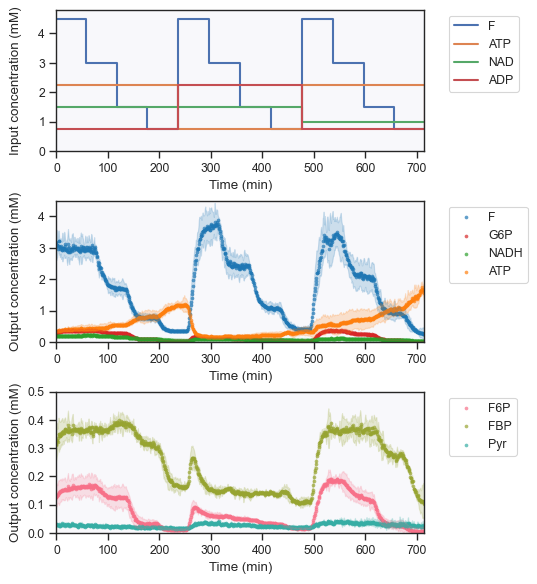

In [8]:
compare_df = pd.DataFrame()
compare_df.index = quantif_df.index
compare_df["F_avg"] = quantif_df[['F_34', 'F_35']].mean(axis=1)
compare_df["F_std"] = quantif_df[['F_34', 'F_35']].std(axis=1)
compare_df["G6P_avg"] = quantif_df[['G6P_34', 'G6P_35']].mean(axis=1)
compare_df["G6P_std"] = quantif_df[['G6P_34', 'G6P_35']].std(axis=1)
compare_df["NADH_avg"] = quantif_df[['NADH_34', 'NADH_35']].mean(axis=1)
compare_df["NADH_std"] = quantif_df[['NADH_34', 'NADH_35']].std(axis=1)
compare_df["ATP_avg"] = quantif_df[['ATP_34', 'ATP_35']].mean(axis=1)
compare_df["ATP_std"] = quantif_df[['ATP_34', 'ATP_35']].std(axis=1)
compare_df["F6P_avg"] = quantif_df[['F6P_34', 'F6P_35']].mean(axis=1)
compare_df["F6P_std"] = quantif_df[['F6P_34', 'F6P_35']].std(axis=1)
compare_df["FBP_avg"] = quantif_df[['FBP_34', 'FBP_35']].mean(axis=1)
compare_df["FBP_std"] = quantif_df[['FBP_34', 'FBP_35']].std(axis=1)
compare_df["Pyr_avg"] = quantif_df[['Pyr_34', 'Pyr_35']].mean(axis=1)
compare_df["Pyr_std"] = quantif_df[['Pyr_34', 'Pyr_35']].std(axis=1)
compare_df.index = (compare_df.index / 60) -60 #s to min and removing the first 60 minutes of equilibration

colors = sns.color_palette('husl', 4)

fig, ax = plt.subplots(3,1)
sns.lineplot(data = df_inputgraph, x="time", y="F", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="F", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ADP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ADP", palette="tab10")

sns.scatterplot(data=compare_df, x=compare_df.index, y="F_avg", s=7, alpha=0.7, linewidth=0, label="F", color='tab:blue', ax=ax[1])
sns.scatterplot(data=compare_df, x=compare_df.index, y="G6P_avg", s=7, alpha=0.7, linewidth=0, label="G6P", color='tab:red', ax=ax[1])
sns.scatterplot(data=compare_df, x=compare_df.index, y="NADH_avg", s=7, alpha=0.7, linewidth=0, label="NADH", color='tab:green', ax=ax[1])
sns.scatterplot(data=compare_df, x=compare_df.index, y="ATP_avg", s=7, alpha=0.7, linewidth=0, label="ATP", color='tab:orange', ax=ax[1])
sns.scatterplot(data=compare_df, x=compare_df.index, y="F6P_avg", s=7, alpha=0.7, linewidth=0, label="F6P", color=colors[0], ax=ax[2])
sns.scatterplot(data=compare_df, x=compare_df.index, y="FBP_avg", s=7, alpha=0.7, linewidth=0, label="FBP", color=colors[1], ax=ax[2])
sns.scatterplot(data=compare_df, x=compare_df.index, y="Pyr_avg", s=7, alpha=0.7, linewidth=0, label="Pyr", color=colors[2], ax=ax[2])

ax[1].fill_between(compare_df.index, compare_df["F_avg"] - compare_df["F_std"], compare_df["F_avg"] + compare_df["F_std"], color='tab:blue', alpha=0.2)
ax[1].fill_between(compare_df.index, compare_df["G6P_avg"] - compare_df["G6P_std"], compare_df["G6P_avg"] + compare_df["G6P_std"], color='tab:red', alpha=0.2)
ax[1].fill_between(compare_df.index, compare_df["NADH_avg"] - compare_df["NADH_std"], compare_df["NADH_avg"] + compare_df["NADH_std"], color='tab:green', alpha=0.2)
ax[1].fill_between(compare_df.index, compare_df["ATP_avg"] - compare_df["ATP_std"], compare_df["ATP_avg"] + compare_df["ATP_std"], color='tab:orange', alpha=0.2)
ax[2].fill_between(compare_df.index, compare_df["F6P_avg"] - compare_df["F6P_std"], compare_df["F6P_avg"] + compare_df["F6P_std"], color=colors[0], alpha=0.2)
ax[2].fill_between(compare_df.index, compare_df["FBP_avg"] - compare_df["FBP_std"], compare_df["FBP_avg"] + compare_df["FBP_std"], color=colors[1], alpha=0.2)
ax[2].fill_between(compare_df.index, compare_df["Pyr_avg"] - compare_df["Pyr_std"], compare_df["Pyr_avg"] + compare_df["Pyr_std"], color=colors[2], alpha=0.2)


ax[0].set_xlim(0,715)
ax[0].set_ylim(0,4.8)
ax[1].set_xlim(0,715)
ax[1].set_ylim(0,4.5)
ax[2].set_xlim(0,715)
ax[2].set_ylim(0,0.5)
ax[0].set_xlabel("Time (min)")
ax[0].set_ylabel("Input concentration (mM)")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("Output concentration (mM)")
ax[2].set_xlabel("Time (min)")
ax[2].set_ylabel("Output concentration (mM)")

fig.align_ylabels(ax[:])
ax[0].set_facecolor('#F8F8FB')
ax[1].set_facecolor('#F8F8FB')
ax[2].set_facecolor('#F8F8FB')

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplots_adjust(left=None, bottom=None, right=0.7, top=1.2, wspace=None, hspace=0.35)
#plt.savefig('SNMS34_35_Repeatability.svg', format='svg', bbox_inches='tight', dpi=600)

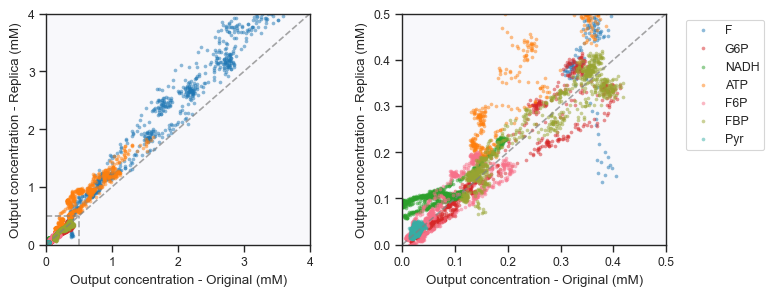

In [9]:
#We filter for t > 5000s and < 46500s to compare the three fist sets of waves, because the CSTR clogged in the replicate measurement
quantif_df = quantif_df[(quantif_df.index < 46500) & (quantif_df.index > 5000)]

x_th = np.linspace(0, 5, 100)
y_th = x_th
x_ver = [0,0.5]
y_ver = [0.5,0.5]
x_hor = [0.5,0.5]
y_hor = [0, 0.5]

colors = sns.color_palette('husl', 4)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.scatterplot(quantif_df, x=quantif_df["F_34"], y=quantif_df["F_35"], s=7, alpha=0.5, linewidth=0, color='tab:blue', ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["G6P_34"], y=quantif_df["G6P_35"], s=7, alpha=0.5, linewidth=0, color='tab:red', ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["NADH_34"], y=quantif_df["NADH_35"], s=7, alpha=0.5, linewidth=0, color='tab:green', ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["ATP_34"], y=quantif_df["ATP_35"], s=7, alpha=0.5, linewidth=0, color='tab:orange', ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["F6P_34"], y=quantif_df["F6P_35"], s=7, alpha=0.5, linewidth=0, color=colors[0], ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["FBP_34"], y=quantif_df["FBP_35"], s=7, alpha=0.5, linewidth=0, color=colors[1], ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["Pyr_34"], y=quantif_df["Pyr_35"], s=7, alpha=0.5, linewidth=0, color=colors[2], ax=ax[0])
sns.scatterplot(quantif_df, x=quantif_df["F_34"], y=quantif_df["F_35"], s=7, alpha=0.5, linewidth=0, label="F", color='tab:blue', ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["G6P_34"], y=quantif_df["G6P_35"], s=7, alpha=0.5, linewidth=0, label="G6P", color='tab:red', ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["NADH_34"], y=quantif_df["NADH_35"], s=7, alpha=0.5, linewidth=0, label="NADH", color='tab:green', ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["ATP_34"], y=quantif_df["ATP_35"], s=7, alpha=0.5, linewidth=0, label="ATP", color='tab:orange', ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["F6P_34"], y=quantif_df["F6P_35"], s=7, alpha=0.5, linewidth=0, label="F6P", color=colors[0], ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["FBP_34"], y=quantif_df["FBP_35"], s=7, alpha=0.5, linewidth=0, label="FBP", color=colors[1], ax=ax[1])
sns.scatterplot(quantif_df, x=quantif_df["Pyr_34"], y=quantif_df["Pyr_35"], s=7, alpha=0.5, linewidth=0, label="Pyr", color=colors[2], ax=ax[1])
ax[0].plot(x_th,y_th, c='grey', linestyle='--', alpha=0.7)
ax[0].plot(x_ver,y_ver, c='grey', linestyle='--', alpha=0.7)
ax[0].plot(x_hor,y_hor, c='grey', linestyle='--', alpha=0.7)

ax[1].plot(x_th,y_th, c='grey', linestyle='--', alpha=0.7)

ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax[0].set_xlim(0,4)
ax[0].set_ylim(0,4)
ax[1].set_xlim(0,0.5)
ax[1].set_ylim(0,0.5)

ax[0].set_xlabel("Output concentration - Original (mM)")
ax[0].set_ylabel("Output concentration - Replica (mM)")
ax[1].set_xlabel("Output concentration - Original (mM)")
ax[1].set_ylabel("Output concentration - Replica (mM)")

ax[0].set_yticks([0, 1, 2, 3, 4], minor=False)

fig.align_xlabels(ax[:])
ax[0].set_facecolor('#F8F8FB')
ax[1].set_facecolor('#F8F8FB')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
#plt.savefig('SNMS34_35_Repeatability_scattercomparison.svg', format='svg', bbox_inches='tight', dpi=600)